In [101]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=cpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold

In [117]:
v = check(what="notebook", 
          #filename="..//model.pkl", 
          filename="../training/reproduce_bengio_denoising/fonts/model.pkl",
          dataset="fonts",
          force_w=28,
          force_h=28)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'seed': 2}


In [118]:
capsule, data, layers, w, h, c = v
print(w, h, c)
print(layers.keys())

(28, 28, 1)
['input', 'hid', 'hid_sparse', 'pre_output', 'output']


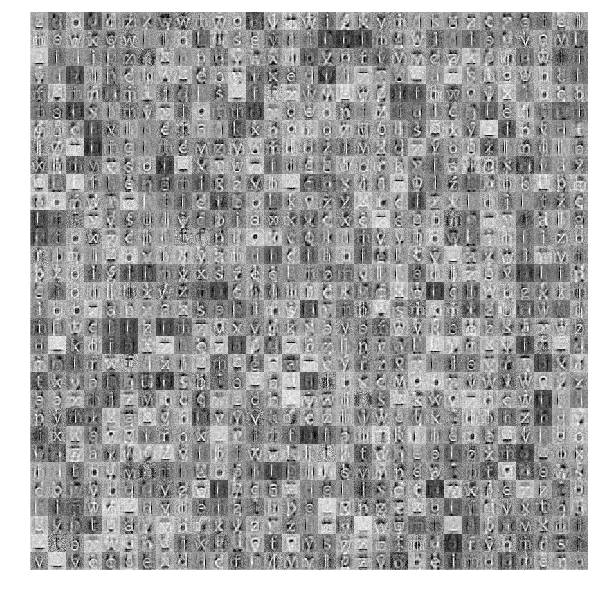

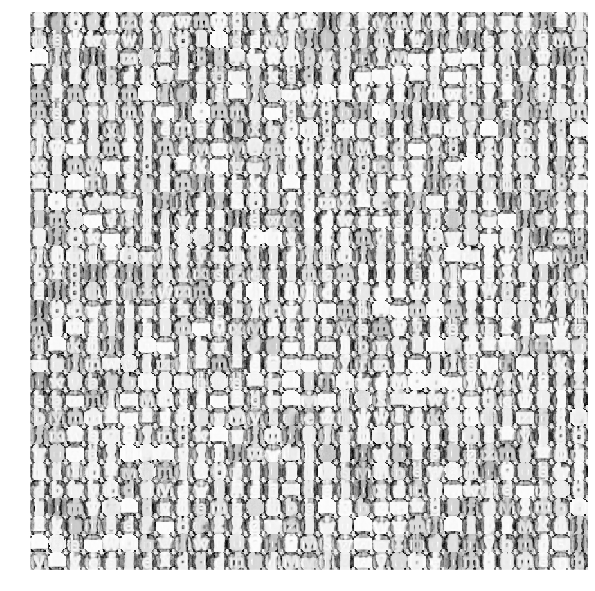

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
for name, layer in layers.items():
    #print(name, layer.output_shape)
    #if hasattr(layer, "W"):
    #    print(layer.W.get_value().shape)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

In [125]:
hid_nonlinearity = 'sigmoid'
out_nonlinearity = 'sigmoid'

def get_deriv(func, x, direct=False):
    if func == 'sigmoid':
        if direct:
            x_ = x
        else:
            x_ = T.nnet.sigmoid(x)
        return x_ * (1 - x_)
    elif func == 'tanh':
        if direct:
            x_  = x
        else:
            x_ = T.tanh(x)
        return 1 - x_ **2

In [126]:
X = T.tensor4()

Xrec = lasagne.layers.get_output(layers['output'], X)
Xrec = Xrec.reshape((Xrec.shape[0], -1))

xflat = X.reshape((X.shape[0], -1))
W = layers['hid'].W#p, h
R = layers['pre_output'].W#h, p

print(layers['pre_output'].W.get_value().shape)
A = get_deriv(hid_nonlinearity, xflat) #n, p (derivative of activation function)
J = T.tensordot(R[None, :, :] * A[:, None, :], W, axes=([1], [1]))
J = J * get_deriv(out_nonlinearity, Xrec, direct=True)[:, :, None]
#symmetricity mesure (see : http://arxiv.org/pdf/1506.07643v3.pdf)
def norm(a):
    if a.ndim == 3:
        axes = (1, 2)
    else:
        axes = tuple(range(a.ndim))
    return (a ** 2).sum(axis=axes)
def symmetricity(J):
    if J.ndim == 3:
        J_t = J.transpose((0, 2, 1))
    else:
        J_t = J.T
    return norm(0.5 * (J + J_t))/ norm(J)

#J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
J = J.reshape((J.shape[0],))
get_jacobian = theano.function([X], J)

(1000, 784)


In [127]:
X = T.vector()
Xrec = lasagne.layers.get_output(layers['output'], X.reshape((1, c, w, h)))
Xrec = Xrec.flatten()
J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
get_jacobian = theano.function([X], J)

In [128]:
m = np.dot(layers['pre_output'].W.get_value().T, layers['hid'].W.get_value().T)
print(symmetricity(m))

0.546536


In [131]:
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

In [139]:
import numpy as np
seed = 42
#seed = np.random.randint(0, 99999)
#np.random.seed(seed)
jac = []
N = 100
s = np.random.uniform(size=(N, c, w, h))
s = s.astype(np.float32)
samples = []

samples.append(s.copy())

#idx = np.random.randint(0, data.X.shape[0])
#s = data.X[idx:idx + 1].reshape((1, c, w, h))

print(s.shape)
loss = []
al = 2
for i in range(200):
    sprev = s    
    #s = capsule.reconstruct(salt_and_pepper(s, corruption_level=0.3, backend='numpy'))
    s = capsule.reconstruct(s)
    s = s.astype(np.float32)
    samples.append(s.copy())
    #samples = s.copy()
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    #s = s > 0.5
    #s = sample(s)
    #j = get_jacobian(s.flatten())
    #jac.append(j)
    #print(j.mean())
    score = np.abs(s - sprev).sum()
    print(score)
    loss.append(score)
    #if score == 0:
    #    break
samples = np.concatenate(samples, axis=0)
#print(samples.shape)
#samples = s
#print(samples.shape)

(100, 1, 28, 28)
27658.6
4302.92
3985.31
3797.15
3485.05
3399.99
2940.9
2764.28
2715.0
2588.67
2645.24
2316.17
1971.33
2079.03
2078.52
2102.57
2035.07
2057.72
1877.67
2016.8
1876.92
1792.16
1845.47
1976.56
2163.18
2218.75
2054.85
2010.88
1669.09
1582.03
1642.93
1481.0
1566.23
1506.31
1486.03
1576.87
1811.57
2105.24
1957.7
1769.76
1892.29
1967.51
2223.77
2048.61
2150.16
1876.8
1777.62
1671.17
1790.94
1957.16
1887.82
1979.22
1902.16
1815.31
1736.0
1664.87
1794.59
2087.69
1898.14
1589.33
1445.69
1432.75
1323.12
1244.02
1221.93
1197.83
1240.9
1246.26
1308.31
1349.91
1294.37
1437.69
1509.75
1585.53
1697.24
1753.21
1690.15
1297.43
1255.53
1435.65
1666.08
1516.85
1569.29
1744.64
1938.03
1748.81
1584.62
1528.7
1661.27
1614.1
1509.69
1474.0
1572.23
1450.44
1522.27
1758.8
1851.23
1702.03
1726.84
1816.83
1874.81
2027.22
1991.76
2070.38
1942.39
1427.46
1075.24
927.046
873.821
897.949
917.929
1043.51
1122.91
1109.62
1079.51
1219.48
1645.17
1920.76
1987.55
2187.89
2421.55
2218.29
1951.98
2090.56
192

('Nb of iterations', 200)


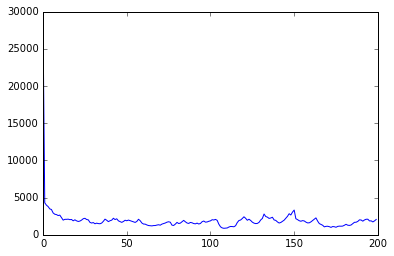

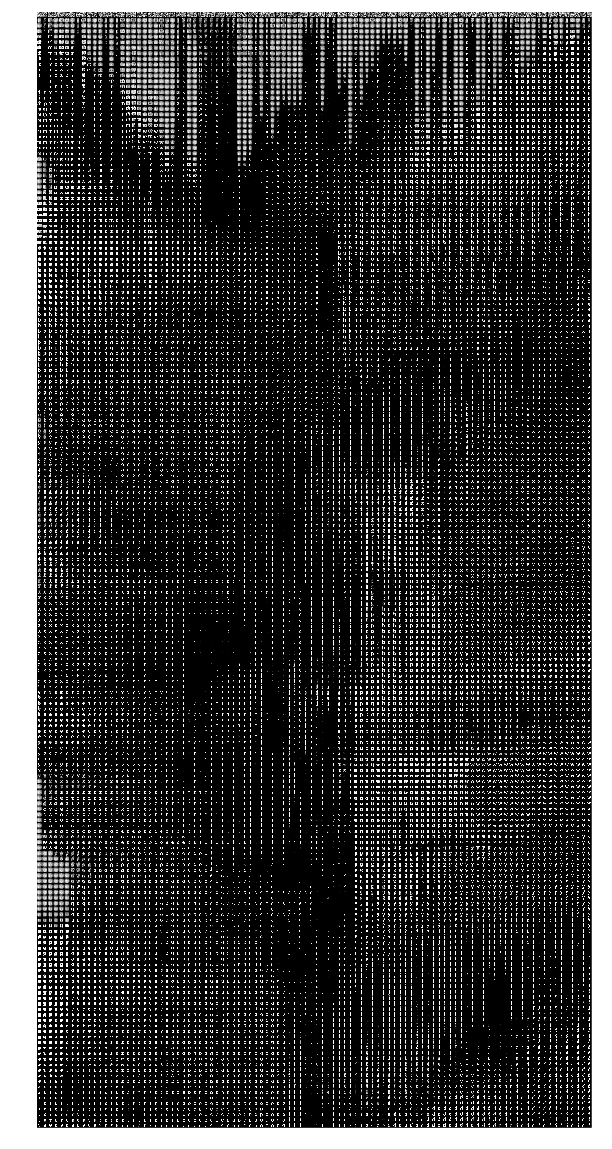

In [140]:
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave
plt.plot(loss)
print("Nb of iterations", len(loss))
fig = plt.figure(figsize=(20, 20))
if samples.shape[1] == 1:
    sz = int(np.sqrt(samples.shape[0]))
    sz = samples.shape[0]/10
    img = tile_raster_images(samples[:, 0], (w, h), (samples.shape[0]/N, N), tile_spacing=(2, 2), )
    imsave('out.png', img)
    plt.imshow(img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
else:
    ss = s.transpose((0, 2, 3, 1))
    img = dispims_color(ss)
    plt.imshow(img)
    plt.axis('off')
    plt.show()